# Mathematics and Computational Methods for Complex Systems

In [26]:
#Preliminary imports
import math
import pandas as pd
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

## Assignment 2 - Analytical Work

**3) Produce the bifurcation plot for this system, that is, plot the value of the equilibria
as a function of R0, with R0 taking values from 0.1 to 5.0. For this question, the
value of N is irrelevant (provided it’s strictly positive) so use 1000 for example.
This should be done using Matlab/Python.**

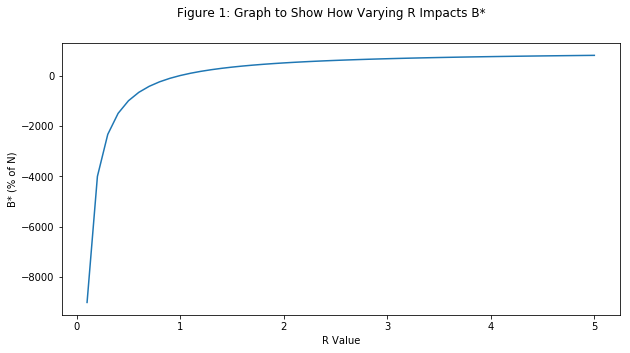

In [36]:
N = 1000
Bstar = []
R = np.linspace(0.1,5)

for x in range(len(R)):
    Bstar.append(N-(N/R[x])) #Formula for B*

#Plot Results
plt.figure(figsize=(10,5))
plt.plot(R, Bstar)
plt.xlabel("R Value")
plt.ylabel("B* (% of N)")
plt.suptitle("Figure 1: Graph to Show How Varying R Impacts B*")
plt.show()

**5) plot solutions of [B](t) for various values of R0 between 0.1 and 5.0 (with γ = 0.5
for example). Confirm your expression for [B](t) is correct by (a) verifying that
it converges to B∗ for large times t and (b) visually confirming agreement when
integrating the mean-field equation using Euler (use Matlab/Python).**

In [57]:
#Factor in fixed t val
def bEquation(b0, N, beta, gamma, t):
    bStar = ((beta*N-N*gamma)/beta)
    return (bStar/((bStar/b0-1)*math.e**((gamma-beta)*t)+1))

Text(0, 0.5, '[B](t)')

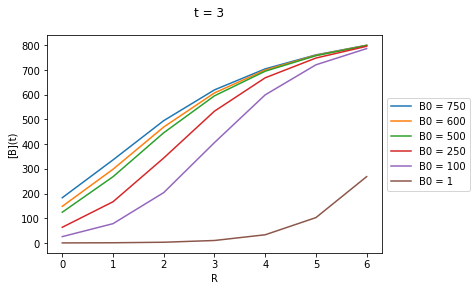

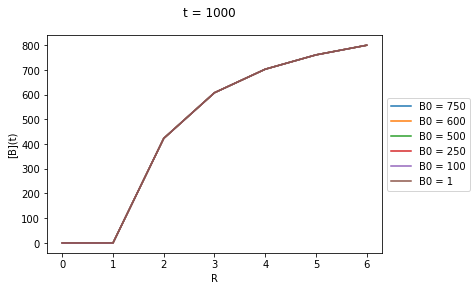

In [60]:
N=1000
B0=[750,600, 500, 250, 100,1]
#beta=[0.05, 0.5, 1.5, 2, 2.5]
beta = np.linspace(0.05, 2.5, 7)
gamma=0.5

bt, bt8, R = [],[], []

for i in range(len(beta)):
    R.append(beta[i]/gamma)

for x in range(len(B0)):
    for y in range(len(beta)):
        #Catches division by 0 in the case 
        try:
            b = bEquation(B0[x], N, beta[y], gamma, 3)
            b1 = bEquation(B0[x], N, beta[y], gamma, 1000)
        except:
            b = 0
            b1 = 0
        bt.append(b)
        bt8.append(b1)

        
    #Plots
    plt.figure(1)
    plt.xlabel("R")
    plt.ylabel("[B](t)")
    plt.suptitle("t = 3")
    plt.plot(bt, label="B0 = {}".format(B0[x]))
    #plt.plot(R, bt, label="B0 = {}".format(B0[x]))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.figure(2)
    plt.suptitle("t = 1000")
    plt.plot(bt8, label="B0 = {}".format(B0[x]))
    #plt.plot(R, bt8, label="B0 = {}".format(B0[x]))
    bt,bt8 = [],[]
    

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel("R")
plt.ylabel("[B](t)")

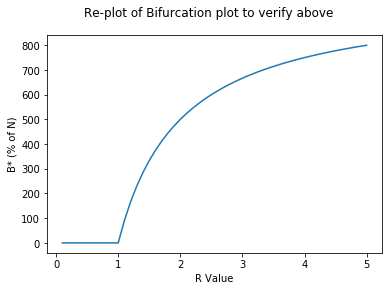

In [65]:
N = 1000
Bstar = []
R = np.linspace(0.1,5)

#Limit the domain to mirror above
for x in range(len(R)):
    b = N-(N/R[x])
    if b >= 0:
        Bstar.append(N-(N/R[x])) 
    else:
        Bstar.append(0)    

#Plot Results
plt.plot(R, Bstar)
plt.xlabel("R Value")
plt.ylabel("B* (% of N)")
plt.suptitle("Re-plot of Bifurcation plot to verify above")
plt.show()

In [2]:
def meanField(B, N, beta, gamma):
    mf = (beta*B)/N*(N-B)-(gamma*B)
    return mf

In [20]:
#Euler method for integration
def euler(N, b0, beta, gamma, Tmax, step):
    currentTime = 0
    times = []
    times.append(currentTime)
    B0 = []
    B0.append(b0)
    
    while currentTime <= Tmax:
        euler = b0 + step * meanField(b0, N, beta, gamma)
        b0 = euler
        if b0 < 0:
            b0 = 0
        B0.append(b0)
        times.append(currentTime)
        currentTime += step
        
    return b0, times, B0

Text(0, 0.5, '[B](t)')

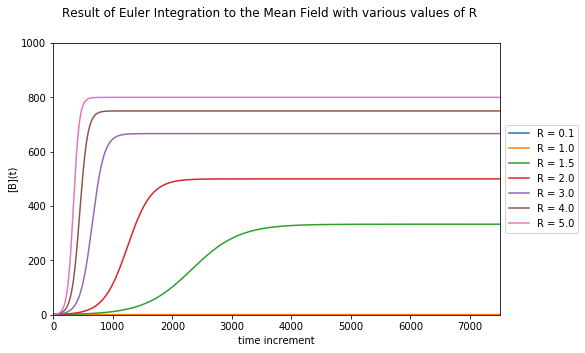

In [68]:
N = 1000
b0 = 1
beta = [0.05, 0.5, 0.75, 1, 1.5, 2, 2.5]
gamma = 0.5
Tmax = 75
Tstep = 0.01

plt.figure(figsize=(8,5))
for x in range(len(beta)):
    R = beta[x]/gamma
    b, times, B0 = euler(N, b0, beta[x], gamma, Tmax, Tstep)
    plt.plot(B0, label='R = {}'.format(R))
    plt.axis([0,len(times), 0, 1000])

    plt.suptitle("Result of Euler Integration to the Mean Field with various values of R")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel("time increment")
plt.ylabel("[B](t)")

## Assignment 2 - Simulation Work

In [71]:
# 26 November 2018 v1.1
# Luc Berthouze
from random import expovariate # Generate variates from exponential distribution
import numpy as np

def gillespie_ABA(N,B0,beta,gamma,Tmax):
    A=[N-B0] # We cannot predict how many elements there will be unfortunately
    B=[B0]
    T=[0] 
    state = np.random.permutation([0]*(N-B0)+[1]*B0) # Randomly allocate B0 individuals to have state B (state=1), A (state=0) otherwise 
    B_contacts = np.where(state==1)[0] # Index of individuals in state B (state=1).
    rate_vector = B0*beta*np.ones((N,1))/N # Set rates to be B0*beta/N (rate for individuals in state A) to all individuals (initialisation). 
    rate_vector[B_contacts] = gamma # Update rate of B_contacts to be gamma (the rate for individuals in state B)
    
    time = 0
    while time<=Tmax+0.5: # some (arbitrary) buffer after Tmax
        rate = np.sum(rate_vector) # Total rate (refer to Gillespie algorithm for details)
        cumrate = np.cumsum(rate_vector) # Cumulated sum of rates
        if rate > 0.000001: # if rate is sufficiently large
            tstep = expovariate(rate) # Pick an exponentially distributed time. Beware of difference with exprnd in Matlab where it is 1/rate
            T.append(T[-1]+tstep) # Time of next event. 
            event = np.where(cumrate>np.random.rand()*rate)[0][0] # Find which individual will see its state change 
            if state[event]==0: # individual is in state A 
                A.append(A[-1]-1) # this state A individual becomes state B so number of state A individuals is decreased
                B.append(B[-1]+1) # obviously, number of state B individuals is increased 
                state[event] = 1 # Update state vector
                rate_vector[event] = gamma # Change rate of individual to B->A rate, namely gamma
                A_contacts = np.where(state==0)[0] # List of state A individuals after change
                rate_vector[A_contacts] += beta/N # Update rate of state A individuals to account for the extra state B individual
            else: # individual is in state B
                B.append(B[-1]-1) # this state B individual becomes state A so number of state B individuals is decreased
                A.append(A[-1]+1) # obviously, number of state A individuals is increased
                state[event] = 0 # Update state vector
                A_contacts = np.where(state==0)[0] # List of state A individuals after changes                                
                rate_vector[A_contacts] = beta*len(np.where(state==1)[0])/N # Update rate of state A individuals based on number of B individuals  
        else: # Nothing will happen from now on so we can accelerate the process
            time = T[-1] # current time
            while time <= Tmax + 0.5:
                A.append(A[-1]) # Just keep things as they are
                B.append(B[-1])
                T.append(T[-1]+0.5) # arbitrarily add 0.5 to clock
                time = T[-1]
        # Update time and proceed with loop 
        time = T[-1]         

    return T,A,B    

**1) Explore the behaviour of the system when considering suitably chosen scenarios, i.e., focus on the limit cases (e.g., small $R_0$, large $R_0$ and $R_0 = 1$; small $N$, large $N$; small $B_0$, large $B_0$). For each scenario, use the code provided to
generate many realisations of the stochastic process. Plot all realisations on a
single plot. Make relevant qualitative observations.**

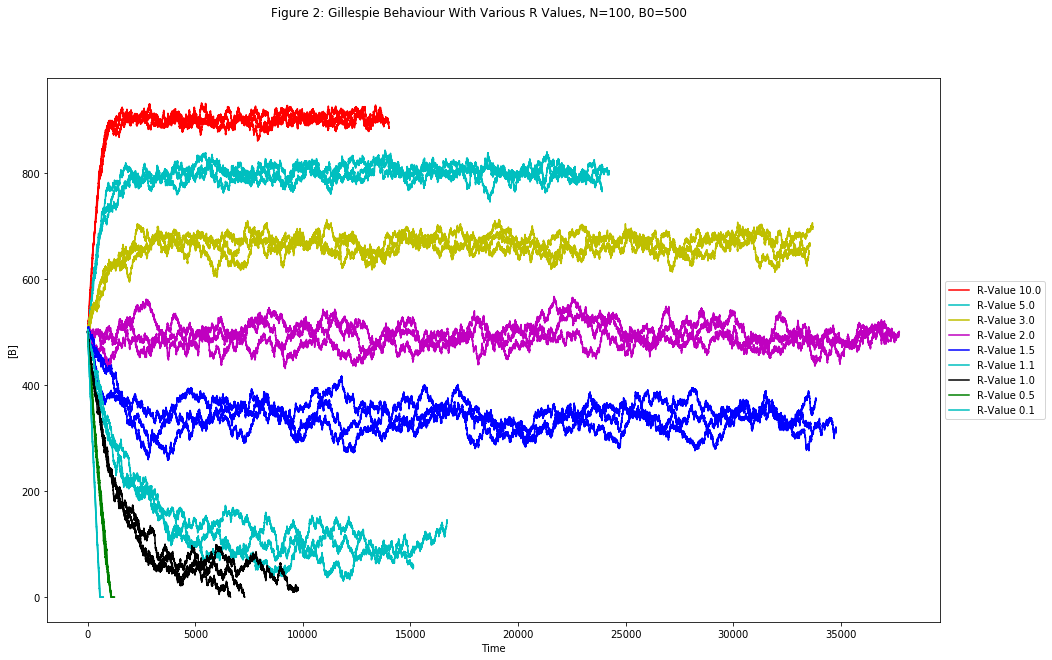

In [37]:
#---------------------------------------------------Varying R value-------------------------------------------------------
N=1000
B0=500
#R = [10, 5, 3, 2, 1.5, 1.1, 1, 0.5, 0.1]
#beta = [1]*len(R)
#gamma = []
#[gamma.append(R[x]/beta[x]) for x in range(len(R))]
#print(gamma)
beta=[1, 1, 1, 1, 1, 1, 1, 1, 1]
gamma=[0.1,0.2,1/3,0.5,2/3, 1/1.1, 1, 2, 10]
Tmax=75

writeLabel = True
iterations = 3
plotCols = ['r', 'c', 'y', 'm', 'b', 'c', 'k', 'g', 'c']

plt.figure(figsize=(16,10))
for x in range(iterations):
    for y in range(len(gamma)):
        T, A, B = gillespie_ABA(N,B0,beta[y],gamma[y],Tmax)
        
        #Only Labels the first iteration of each R value plot
        if writeLabel:
            plt.plot(B, plotCols[y], label="R-Value {}".format(round(beta[y]/gamma[y],3)))
        else:
            plt.plot(B, plotCols[y])
    writeLabel = False
    
    plt.suptitle("Figure 2: Gillespie Behaviour With Various R Values, N=100, B0=500")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.xlabel("Time")
    plt.ylabel("[B]")

$\quad$Above you can visualise the effects of a varying $R$ value on the B population over time, with the Gillespie algorithm. All other variables have been kept constant to allow us to isolate, and therefore investigate, the impact of $R$.

$\quad$The first key difference you may note, is at what value $[B]$ seems to converge towards and find some sort of stability. This should come as no suprise, as in the previous section we calulated $B^*$ to be a function of $N$ and $R$. We can in fact use the plot above to substantiate our findings that $B^* = N - \frac{N}{R_0}$, by substituting in $N = 1000$ in combination with any of the tested $R_0$ values.

e.g $$ B^* = 1000-\frac{1000}{5} = 800 $$ 

When we draw our attention back to the plot, you can see that all realisations plotted with an $R_0$ value of $5$ converge towards the 800 region, needless to say some variation is inevitable due to the stochastic nature of the process. It must also be noted that the manor in which the realisations converge is representative of an exponential decay, since the rate of change of the population of a class is a function of the current population (not time).

$\quad$We are also able to confirm the second equilibrium found during the analytical section - in the case that $[B] = 0$, but not only that, the plot also corroborates with our calculated stabilities. In all cases where $R>1$, each realisation undergoes many perturbations yet never deviates too far from $B^*$, this is exhibitory of a stable system. As soon as $R$ dips below a value of 1, the system becomes unstable for $B^*$, yet the stationary point where $[B] = 0$ remains stable regardless of the value of $R_0$, hence these realisations instead converging towards this equilibria. In the case that $R_0 = 1$..... 

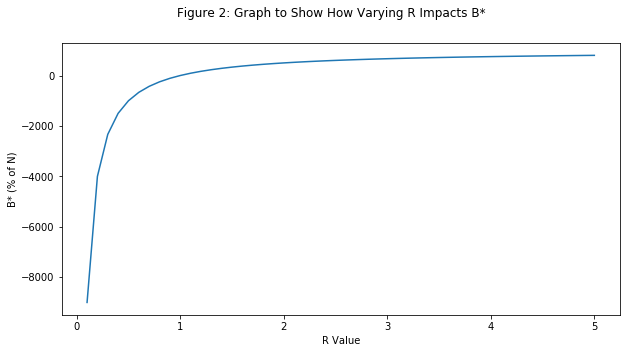

In [33]:
N = 1000
Bstar = []
R = np.linspace(0.1,5)

for x in range(len(R)):
    Bstar.append(N-(N/R[x]))

plt.figure(figsize=(10,5))
plt.plot(R, Bstar)
plt.xlabel("R Value")
plt.ylabel("B* (% of N)")
plt.suptitle("Figure 2: Graph to Show How Varying R Impacts B*")
plt.show()

The above plot serves as an abstraction of the information conveyed in Figure 1, it models how the systems non-zero equilibrium moves in accordance with the value of $R_0$. Once again we see a plot representative of exponential decay (for [A])

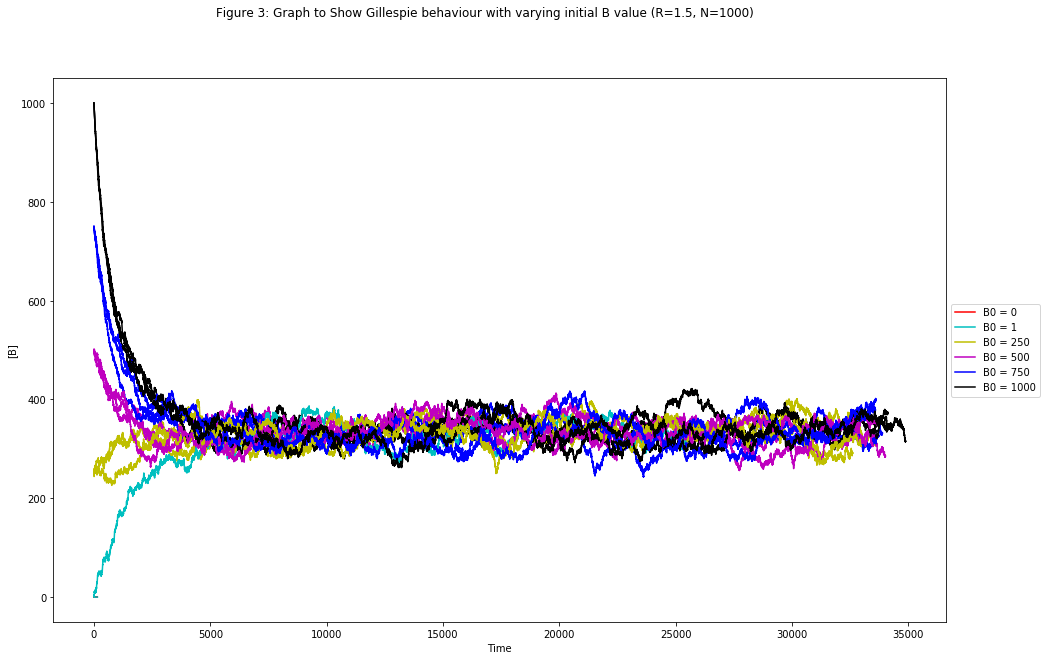

In [4]:
#---------------------------------------------------Varying B0 value-------------------------------------------------------
N=1000
B0=[0,1, 250, 500, 750, 1000]
beta=1
gamma=2/3
Tmax=75

writeLabel = True
iterations = 3
plotCols = ['r', 'c', 'y', 'm', 'b', 'k', 'g', 'c']
plt.figure(figsize=(16,10))

#For each realisation
for x in range(iterations):
    clear_output(wait=True)
    
    #For each initial B value
    for y in range(len(B0)):
        T, A, B = gillespie_ABA(N,B0[y],beta,gamma,Tmax)
        
        #Only Labels the first iteration of each R value plot
        if writeLabel:
            plt.plot(B, plotCols[y], label="B0 = {}".format(B0[y]))
        else:
            plt.plot(B, plotCols[y])
    writeLabel = False #Indicates legend label has been created
        
    #Display Results   
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.xlabel("Time")
    plt.ylabel("[B]")
    plt.suptitle("Figure 3: Graph to Show Gillespie behaviour with varying initial B value (R=1.5, N=1000)")
    #print("Current progress: ",np.round(x/iterations *100, 2), "%")

$\quad$We now turn our attention to varying the inital $[B]$ value. With a constant $R_0$ value, the vast majority of them converge towards the $B^*$ equilibria associated with that $R_0$ value as identified in Figure 1. One exception to this is when $B_0=0$, as this is another stable point from which $[B]$ can't escape. We then have the boundary case where $B_0=1$, due to the degree of stochasticity in play, it is down to chance as to whether those realisations converge to $B^*$ or 0. In the instance above, we can see that it has found itself at the zero equilibrium in $\frac{2}{3}$ of cases. 

In [131]:
#---------------------------------------------------Varying N value-------------------------------------------------------
def plotN(N):
    beta=1
    gamma=2/3
    Tmax=75
    iterations = 3
    b = []

    plt.figure(figsize=(16,10))
    for x in range(iterations):
        B0 = int(N/2)
        T, A, B = gillespie_ABA(N,B0,beta,gamma,Tmax)
        b.append(B)    
    return b

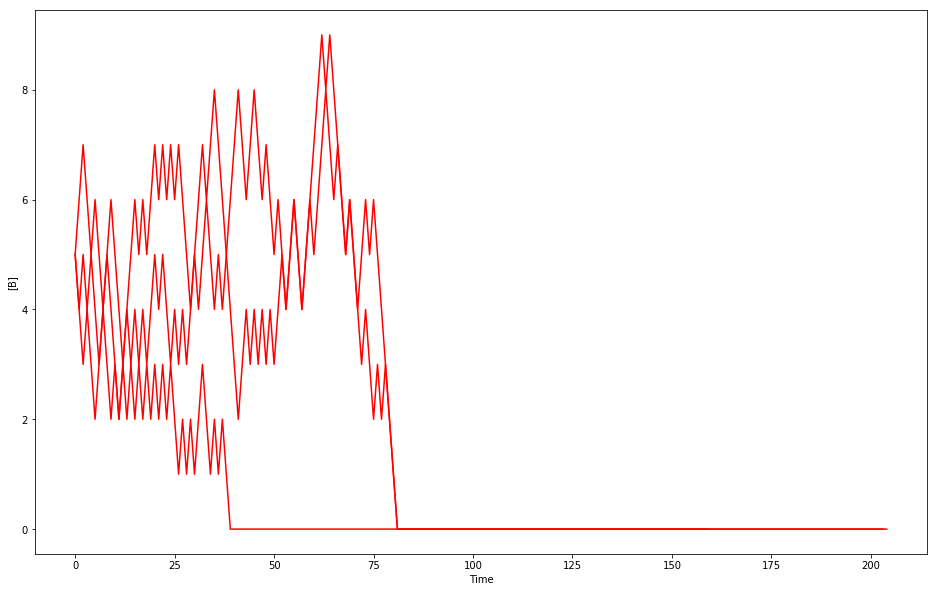

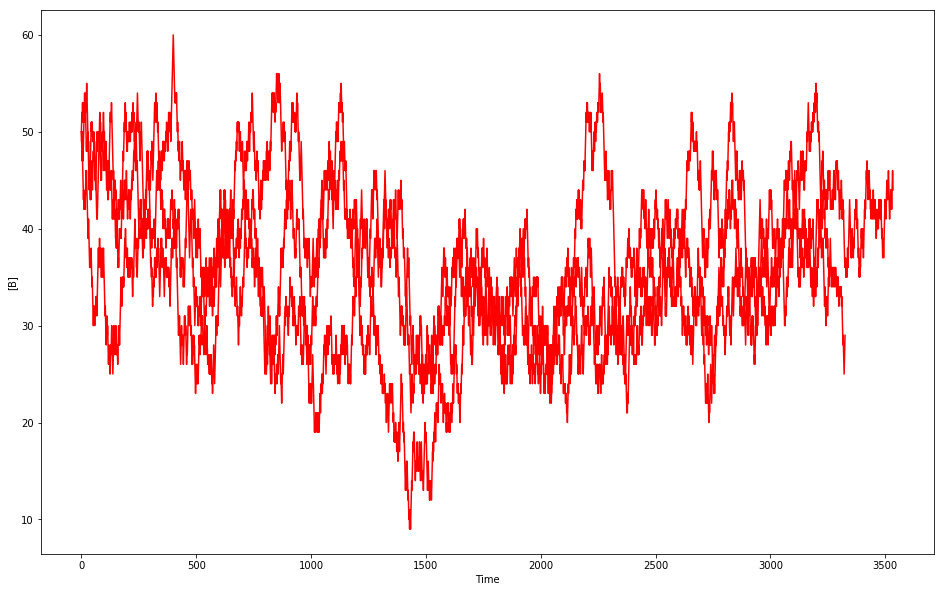

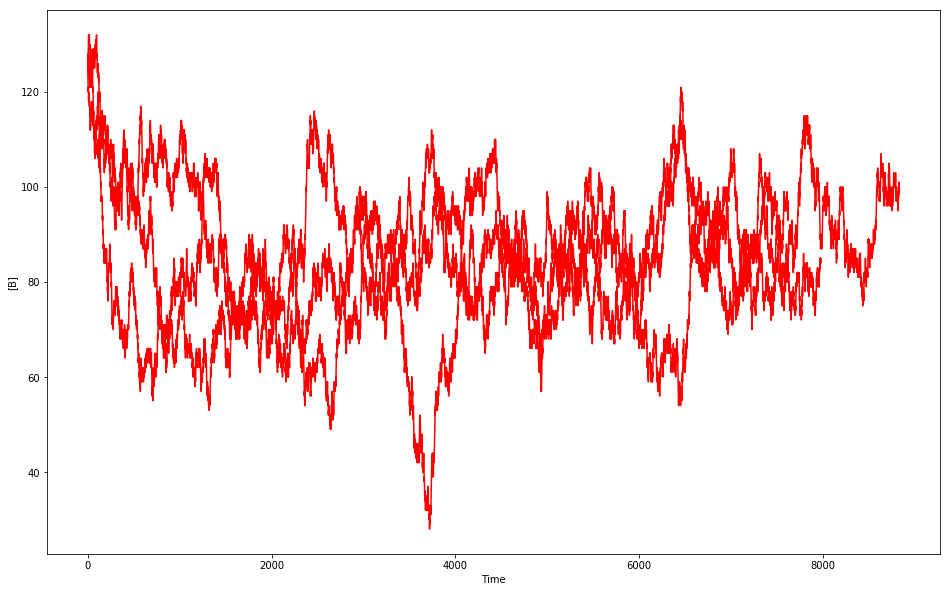

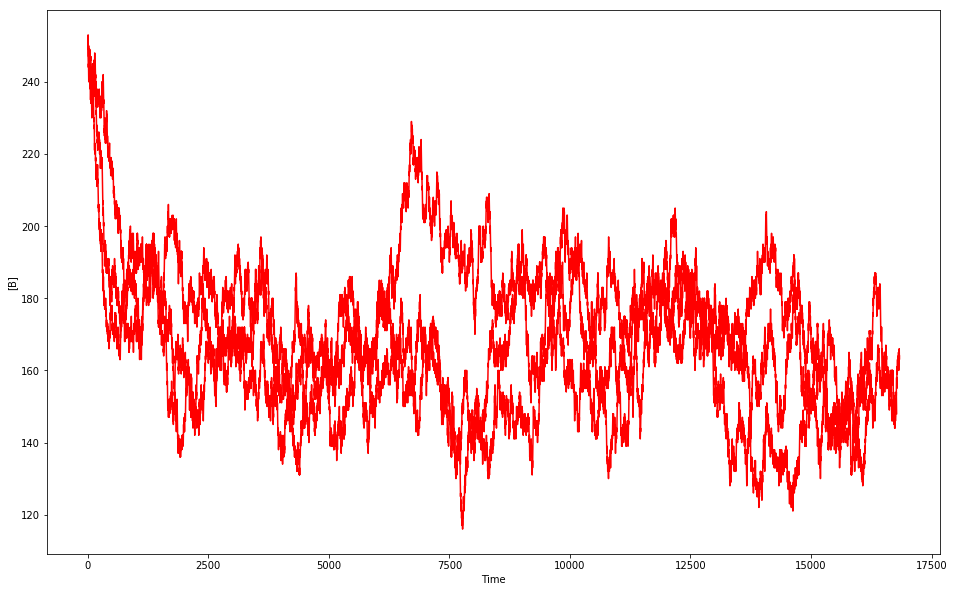

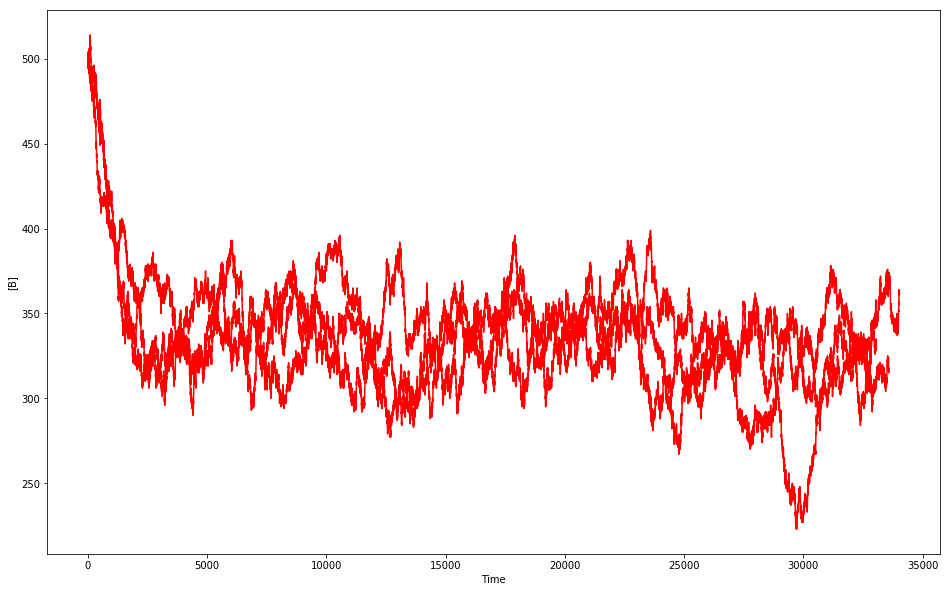

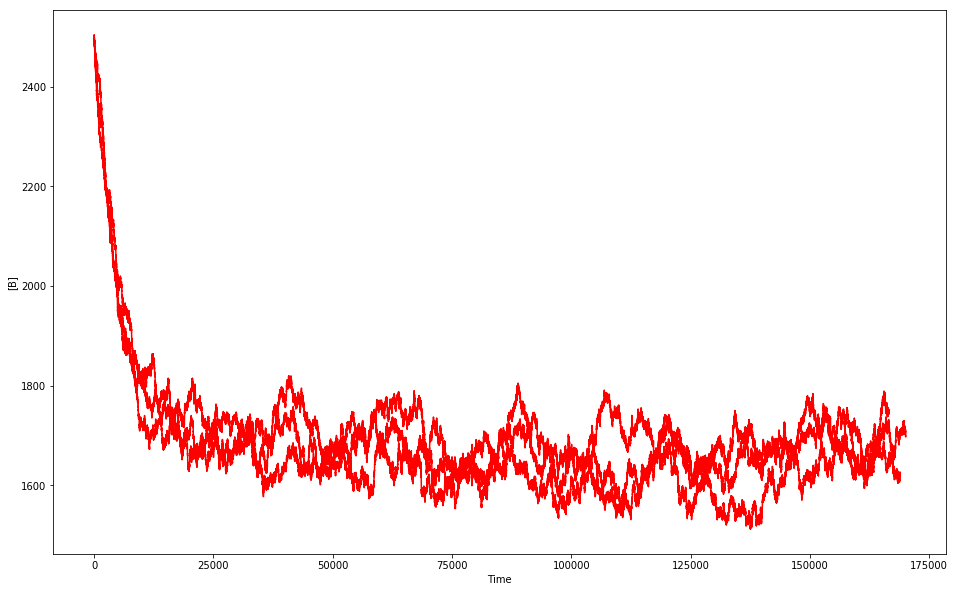

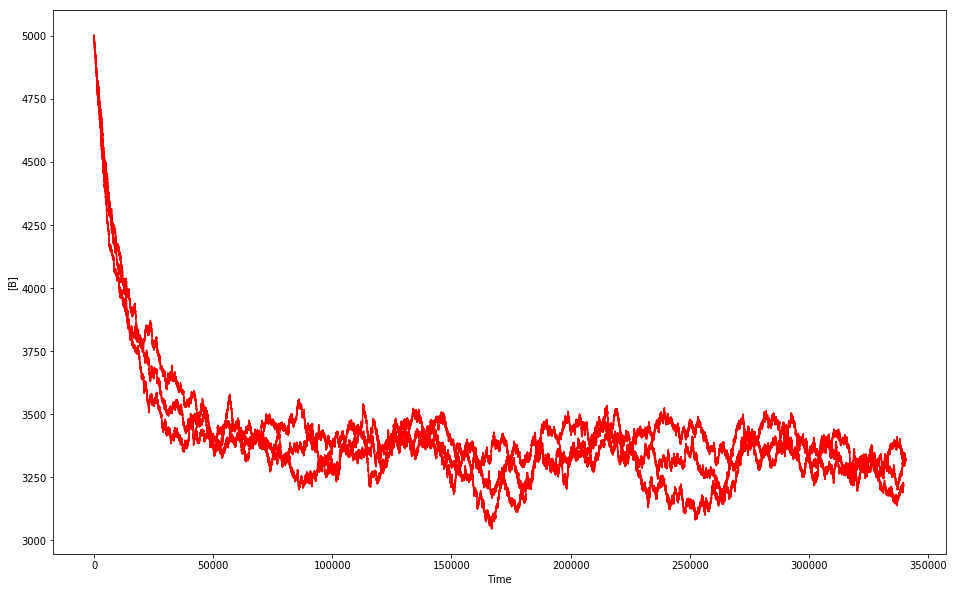

In [49]:
N = [10, 100,250,500,1000,5000, 10000]  
    
for n in range(len(N)):
    data = plotN(N[n])
    for x in range(len(data)):
        plt.plot((data)[x], 'r')
    plt.xlabel("Time")
    plt.ylabel("[B]")

$\quad$The graphs above depict the system with varied $N$ values, at first glance it may appear to bear no real effect on its behaviour. When we take a look at the ODE for B however:
$$\dot{[B]} = \beta \frac{[B]}{N}[A]-\gamma[B]$$

$\quad$We can see that it is partially a function of $N$, hence the variance we see within $[B]$ does scale down relative to the N value being used. This may beg the question of why the overall shapes of the graphs still deteriorate from what you would expect that of an exponential decay to bear relation to, as $N$ is reduced in size. This is because the second term of the ODE ($-\gamma[B]$) is a constant, and so the relative importance of each term shifts as $N$ changes in size. With a large $N$, the first term fades in to insignificance in relation to the constant, resulting in that initial sharp drop in $[B]$ that is characteristic of exponential decay. With smaller $N$ values the contrary is true, hence we no longer see that steep intial decline, and the values now oscillate within a range proportional to $N$.

**2) For each scenario, calculate the average (and standard deviation) of the realisations. Here, you are going to face a problem linked with the nota bene from
the introductory paragraph. You will need to think of a solution and implement
it. Superimpose the average (and error bars) to the realisations. Use a larger
line width for visibility**

In [72]:
"""
This function uses padding to ensure all lists (each representing a single realisation) are of the same length
Params: vals - A list of lists, each inner list represents a single realisation
        padMethod - defines the padding method to be used to ensure all inner-lists are of the same length
                    0 = default, pads with the last value, will factor in to mean calculation
                    1 = pads with no value, will not factor in to mean calculation
Return: vals - Reformatted input, in which all containing lists are of the same length.
"""
def padLists(vals, padMethod=0):
    LongestLen = len(max(vals, key=len))
    for i in range(len(vals)):
        if len(vals[i]) < LongestLen:
            for j in range(len(vals[i]), LongestLen):
                if padMethod == 0:
                    vals[i].append(vals[i][-1]) #Pads with last value
                elif padMethod == 1:
                    vals[i].append("NoVal") #Pads with no value
                else:
                    disp("Invalid Padding Method")
                    break
    return vals

In [73]:
"""
This function calculates the average of all realisations within a scenario. 

Params: vals - A list of lists, each inner list represents a single realisation
        padMethod - defines the padding method to be used to ensure all inner-lists are of the same length
Returns: avg - A single list in which each term is the average of all corresponding terms of the lists contained within vals
"""
def calculateAverage(vals, padMethod=0):
    LongestLen = len(max(vals, key=len))
    termSum = [0]*LongestLen
    avg = [0]*LongestLen
    divisors = [0]*LongestLen
     
    #Pads all inner-lists to same length
    vals = padLists(vals, padMethod)
    
    #Sums all corresponding values within each realisation
    for x in range(LongestLen):
        for y in range(len(vals)):
            if vals[y][x] != "NoVal":
                termSum[x] = termSum[x] + vals[y][x]
                divisors[x] +=1
                
    #Divides all term sums by the amount of no's summed to create it
    for count in range(LongestLen):
        avg[count] = int(termSum[count]/divisors[count])
    return avg

In [74]:
"""
This function calculates the standard deviation between between all realisations at each given time interval
Params: vals - a list of lists, each inner list representing a single realisation
Return: std - a single list, the value at each point is the standard deviation of all realisations at that point
"""
def standardDeviaton(vals):
    pad = padLists(vals)
    std = [0]*len(pad[0])

    #Step 1 - Calculate mean
    avg = calculateAverage(vals)

    #Step 2 - For each no, subtract mean and square result
    for x in range(len(avg)):
        for y in range(len(vals)):
            if vals[y][x] != "NoVal":
                std[x] = (vals[y][x] - avg[x])**2

    #Step 3 - Calculate mean of the squared differences
    std = calculateAverage([std])

    #Step 4 - Square root
    for x in range(len(std)):
        std[x] = math.sqrt(std[x])
    return std

In [75]:
"""
This function calculates the standard error, which dictates how far above and below a given value the error bars extend.
Params: vals - a list of lists, each inner list representing a single realisation
Return: standError - a single list, the value at each point is the standard error between all realisations at that point
"""
def standardError(vals):
    std = standardDeviaton(vals)
    standError = [0]*len(std)

    for x in range(len(std)):
        standError[x] = std[x]/math.sqrt(len(vals))
    return standError

"""
This function applies the standard error to the average line at each point, in order to create the values needed to plot a new
line, to represent where all of the upper (or lower) boundaries of the error bars would lie.
Params: vals - a list of lists, each inner list representing a single realisation
        upper - a boolean to indicate if the upper or lower error-bar boundaries are required
Return: errBar - a plottable list of values, representing the appropriate error bar boundary to an average line.
"""
def errorBar(vals, upper):
    avg = calculateAverage(vals,1)
    stdErr = standardError(vals)
    errBar = [0]*len(avg)

    for x in range(len(avg)):
        if upper:
            errBar[x] = avg[x] + stdErr[x]
        else:
            errBar[x] = avg[x] - stdErr[x]
    return errBar

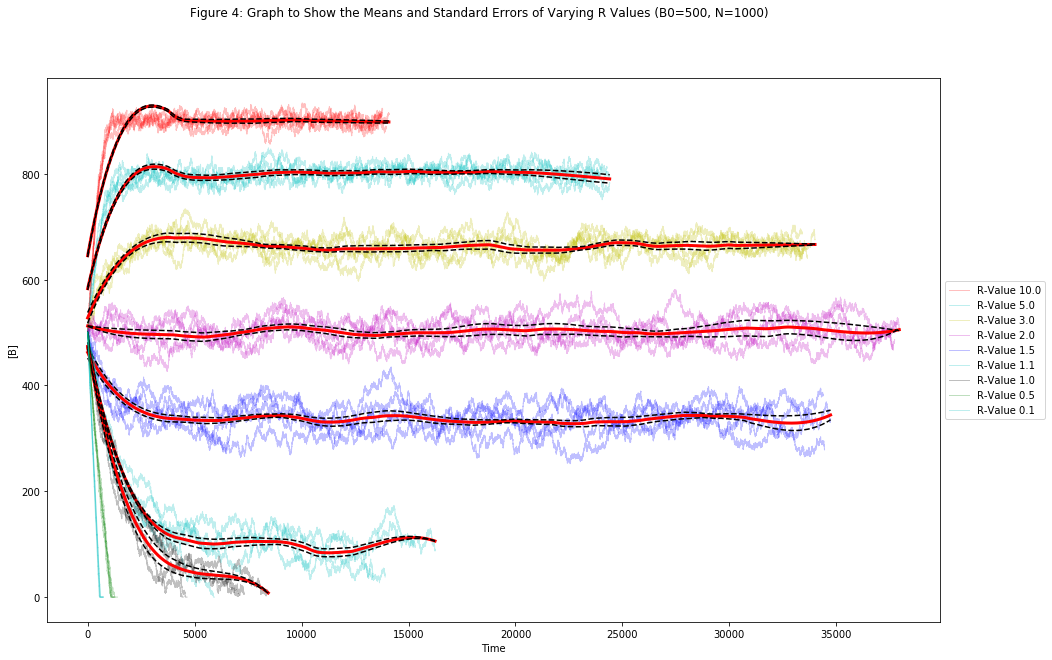

In [10]:
#---------------------------------------------------Varying R value-------------------------------------------------------
N=1000
B0=500
beta=[1, 1, 1, 1, 1, 1, 1, 1, 1]
gamma=[0.1,0.2,1/3,0.5,2/3, 1/1.1, 1, 2, 10]
Tmax=75
windowSize = 7501 #For Savgol smoothing Filter

writeLabel = True
iterations = 5
plotCols = ['r', 'c', 'y', 'm', 'b', 'c', 'k', 'g', 'c']
B_vals = []
plt.figure(figsize=(16,10))

for y in range(len(gamma)):
    writeLabel = True
    
    for x in range(iterations):
        T, A, B = gillespie_ABA(N,B0,beta[y],gamma[y],Tmax)
        B_vals.append(B)
        #Only Labels the first iteration of each R value plot
        if writeLabel:
            plt.plot(B, plotCols[y], label="R-Value {}".format(round(beta[y]/gamma[y],3)),alpha=0.25,linewidth=1)
            writeLabel = False
        else:
            plt.plot(B, plotCols[y], alpha=0.25, linewidth=1)
        
    #Plots Averages + error bar lines
    avg = calculateAverage(B_vals,1)
    if len(avg)>windowSize:
        upperBar = errorBar(B_vals, True)
        lowerBar = errorBar(B_vals, False)
        plt.plot(savgol_filter(avg, 7501, 3), 'r',linewidth=3)
        plt.plot(savgol_filter(upperBar, 7501, 3), 'k--')
        plt.plot(savgol_filter(lowerBar, 7501, 3), 'k--')
    B_vals = []
    
    #Plot Legend, Label Axes
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.xlabel("Time")
    plt.ylabel("[B]")
    plt.suptitle("Figure 4: Graph to Show the Means and Standard Errors of Varying R Values (B0=500, N=1000)")

An alternative approach would be to perform linear interpolation, however I am satisfied with the performance of this approach - having support for multiple different padding options on the shorter lists depending on whether we want them to influence the averages and error bars, or not.

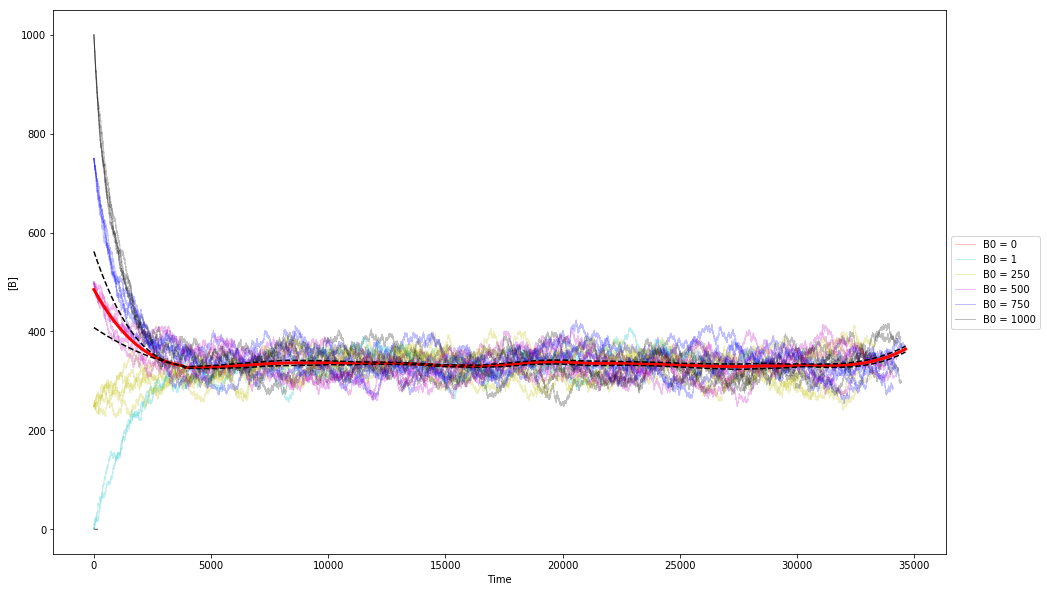

In [117]:
#---------------------------------------------------Varying B0 value-------------------------------------------------------
N=1000
B0=[0,1, 250, 500, 750, 1000]
beta=1
gamma=2/3
Tmax=75

writeLabel = True
iterations = 5
plotCols = ['r', 'c', 'y', 'm', 'b', 'k', 'g', 'c']
B_vals = []

plt.figure(figsize=(16,10))
for x in range(iterations):
    clear_output(wait=True)
    
    for y in range(len(B0)):
        T, A, B = gillespie_ABA(N,B0[y],beta,gamma,Tmax)
        B_vals.append(B)
        
        #Only Labels the first iteration of each R value plot
        if writeLabel:
            plt.plot(B, plotCols[y], label="B0 = {}".format(B0[y]),alpha=0.25,linewidth=1)
        else:
            plt.plot(B, plotCols[y],alpha=0.25,linewidth=1)
    writeLabel = False
        
    #Plot Legend   
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.xlabel("Time")
    plt.ylabel("[B]")
    #print("Current progress: ",np.round(x/iterations *100, 2), "%")
    
#Plot Average and Error-bar lines
avg = calculateAverage(B_vals,1)
upperBar = errorBar(B_vals, True)
lowerBar = errorBar(B_vals, False)
plt.plot(savgol_filter(avg, 7501, 3), 'r',linewidth=3)
plt.plot(savgol_filter(upperBar, 7501, 3), 'k--')
plt.plot(savgol_filter(lowerBar, 7501, 3), 'k--')

In the case of Figure 5 I made the decision to caclulate and plot the average and error bars with respect to all realisations of all scenarios (different $B_0$ values) at each given point. I did this both for readability, as well as because I believe it to be a more useful metric for evaluation. The relationship between the average value for $B_0$, and $B^*$ is causal for that initial drop we see. If we increase the value of $R_0$ to 2, such that $B^*$ becomes equivalent to the average $B_0$, we would no longer see this inital drop from the starting point, to where equilibria is found.

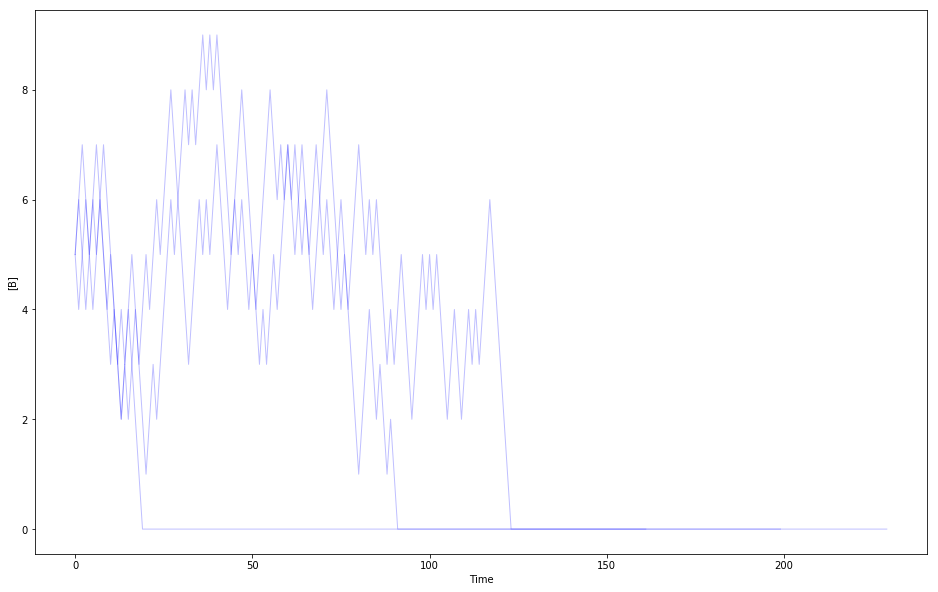

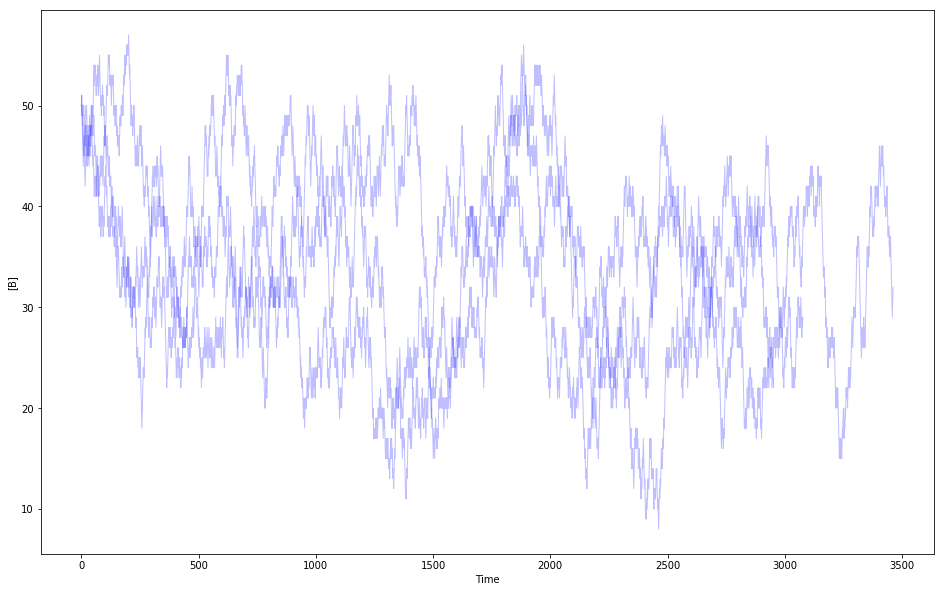

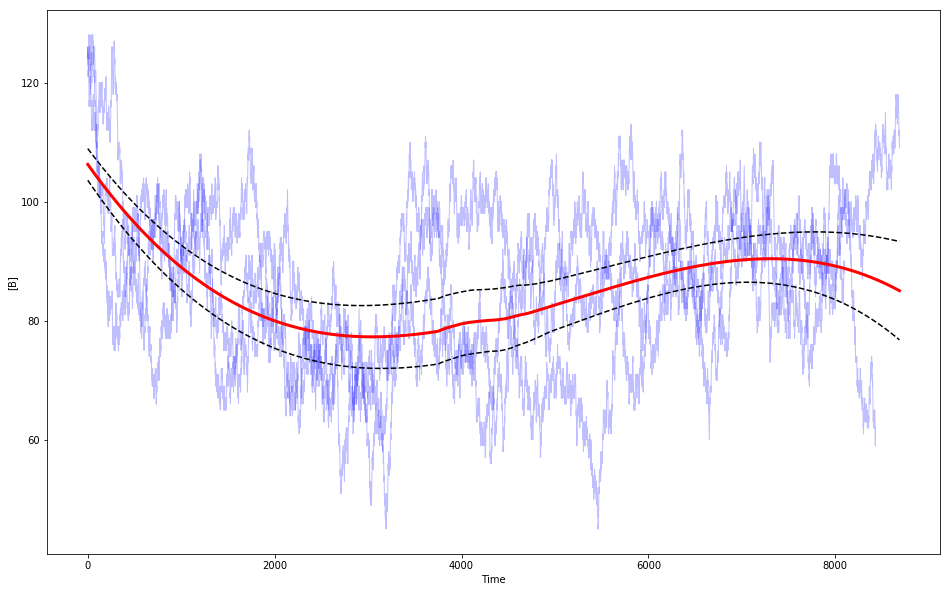

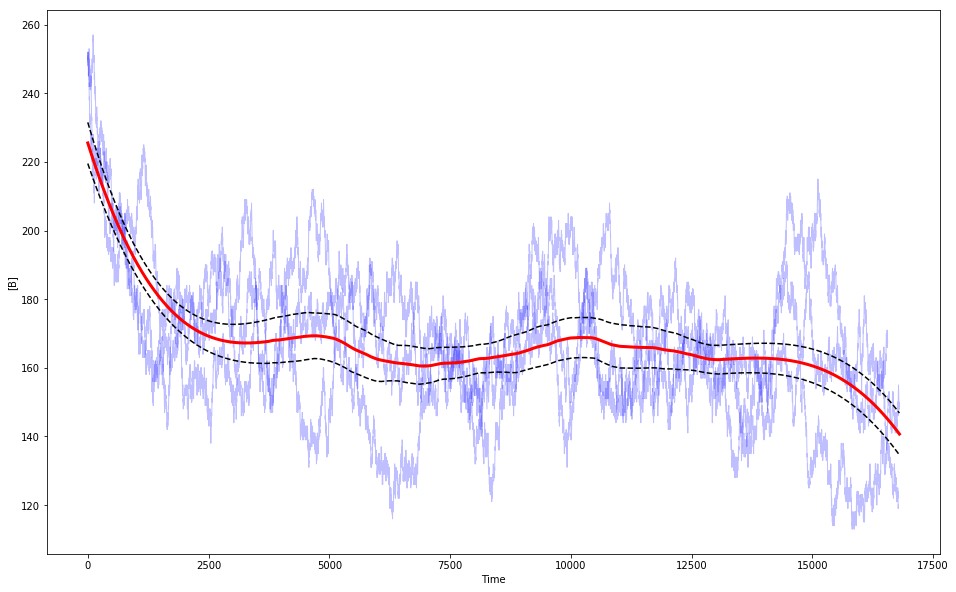

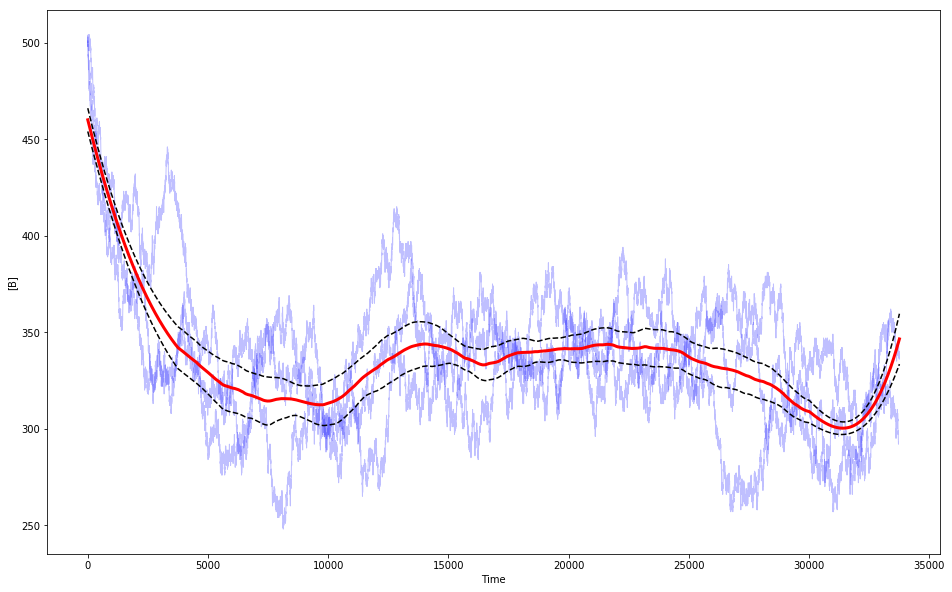

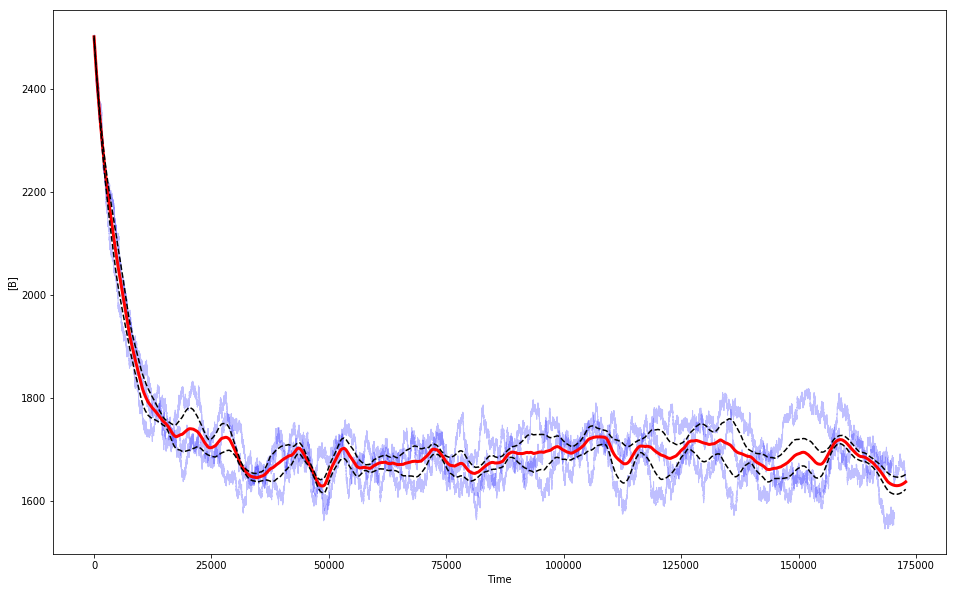

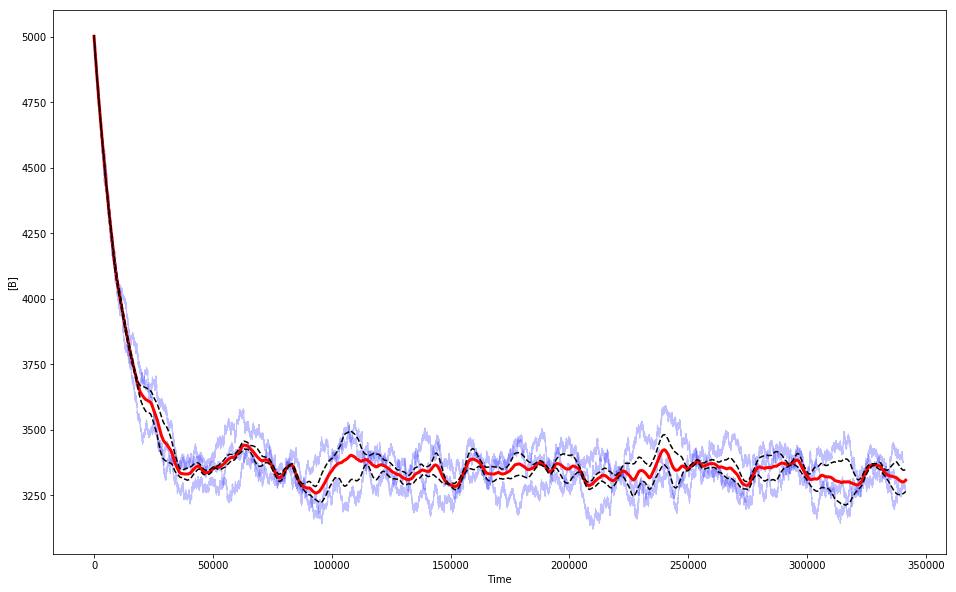

In [134]:
N = [10, 100,250,500,1000,5000, 10000]
windowSize = 7500
    
for n in range(len(N)):
    data = plotN(N[n])
    for x in range(len(data)):
        plt.plot((data)[x], 'b', alpha=0.25, linewidth=1)
    plt.xlabel("Time")
    plt.ylabel("[B]")
    
    avg = calculateAverage(data)
    
    
    
    
    if len(avg) > 7500:
#         windowSize = int(len(avg)/4)
#         if windowSize % 2 == 0:
#             windowSize +=1

        upperBar = errorBar(data, True)
        lowerBar = errorBar(data, False)
        plt.plot(savgol_filter(avg, 7501, 3), 'r',linewidth=3)
        plt.plot(savgol_filter(upperBar, 7501, 3), 'k--')
        plt.plot(savgol_filter(lowerBar, 7501, 3), 'k--')

**3) Finally, superimpose the mean-field solution. Again, use a larger line width and
different colour for visibility. Describe and interpret agreement between average
of stochastic realisations and mean-field in relation to the choice of parameters.
You may want to refer to your bifurcation plot.**

In [69]:
def meanField(B, N, beta, gamma):
    mf = (beta*B)/N*(N-B)-(gamma*B)
    return mf

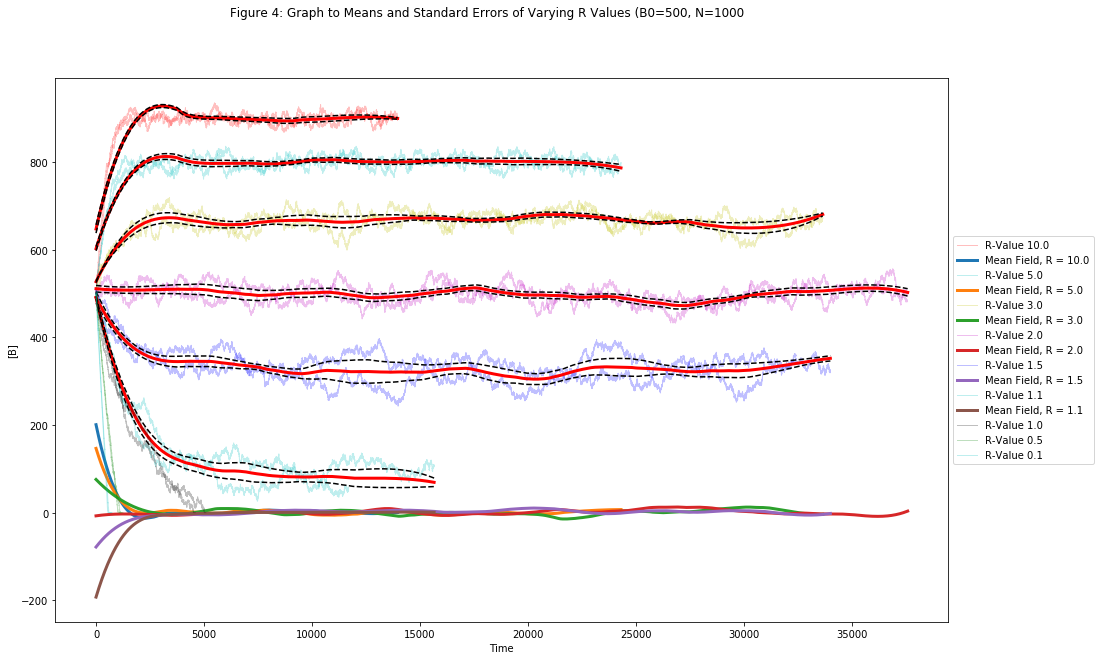

In [89]:
#---------------------------------------------------Varying R value-------------------------------------------------------
N=1000
B0=500
beta=[1, 1, 1, 1, 1, 1, 1, 1, 1]
gamma=[0.1,0.2,1/3,0.5,2/3, 1/1.1, 1, 2, 10]
Tmax=75
windowSize = 7501 #For Savgol smoothing Filter

writeLabel = True
iterations = 2
plotCols = ['r', 'c', 'y', 'm', 'b', 'c', 'k', 'g', 'c']
B_vals, mf = [],[]
plt.figure(figsize=(16,10))

for y in range(len(gamma)):
    writeLabel = True
    
    for x in range(iterations):
        T, A, B = gillespie_ABA(N,B0,beta[y],gamma[y],Tmax)
        B_vals.append(B)
        #Only Labels the first iteration of each R value plot
        if writeLabel:
            plt.plot(B, plotCols[y], label="R-Value {}".format(round(beta[y]/gamma[y],3)),alpha=0.25,linewidth=1)
            writeLabel = False
        else:
            plt.plot(B, plotCols[y], alpha=0.25, linewidth=1)
        

    #Plot Mean Fields
    mf = []       
    avg = calculateAverage(B_vals)
    if beta[y]/gamma[y] > 1:
        for x in range(len(avg)):
            mf.append(meanField(avg[x], N, beta[y], gamma[y]))
        if len(mf) > 5001:
            plt.plot(savgol_filter(mf, 5001, 3), linewidth=3, label="Mean Field, R = {}".format(round(beta[y]/gamma[y],3)))
        else:
            plt.plot(mf, linewidth=3, label="Mean Field, R = {}".format(round(beta[y]/gamma[y],3)))
    
    #Plot Average and Error Bars
    if len(avg)>windowSize:
        upperBar = errorBar(B_vals, True)
        lowerBar = errorBar(B_vals, False)      
        plt.plot(savgol_filter(avg, 7501, 3), 'r',linewidth=3)
        plt.plot(savgol_filter(upperBar, 7501, 3), 'k--')
        plt.plot(savgol_filter(lowerBar, 7501, 3), 'k--')
    B_vals = []
    
    #Plot Legend, Label Axes
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.xlabel("Time")
    plt.ylabel("[B]")
    plt.suptitle("Figure 4: Graph to Means and Standard Errors of Varying R Values (B0=500, N=1000")
    


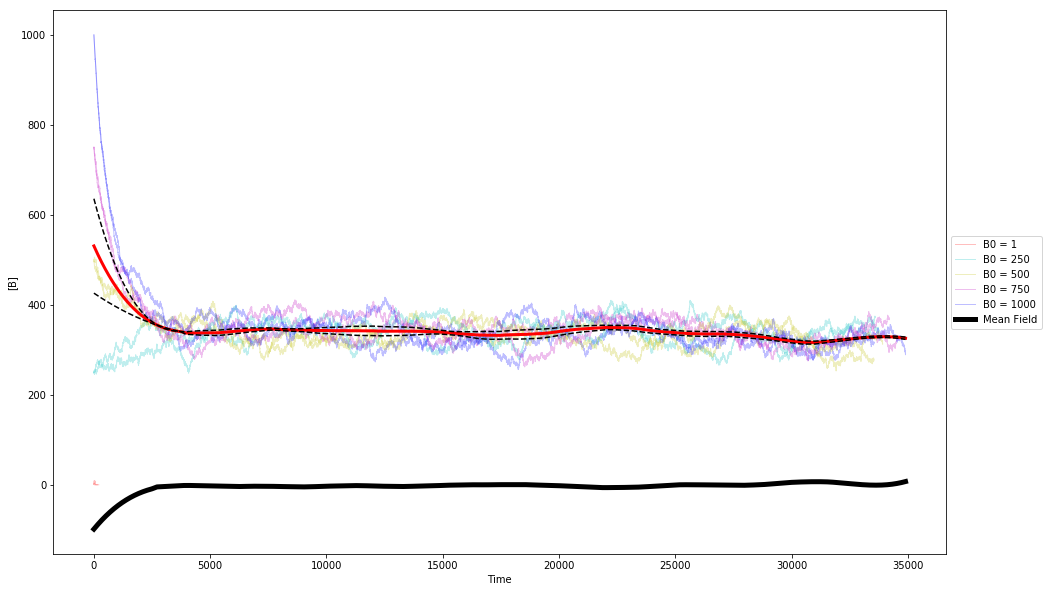

In [25]:
#---------------------------------------------------Varying B0 value-------------------------------------------------------
N=1000
B0=[1, 250, 500, 750, 1000]
beta=1
gamma=2/3
Tmax=75

writeLabel = True
iterations = 2
plotCols = ['r', 'c', 'y', 'm', 'b', 'k', 'g', 'c']
B_vals, mf = [],[]


plt.figure(figsize=(16,10))
for x in range(iterations):
    clear_output(wait=True)
    
    for y in range(len(B0)):
        T, A, B = gillespie_ABA(N,B0[y],beta,gamma,Tmax)
        B_vals.append(B)
        
        #Only Labels the first iteration of each R value plot
        if writeLabel:
            plt.plot(B, plotCols[y], label="B0 = {}".format(B0[y]),alpha=0.25,linewidth=1)
        else:
            plt.plot(B, plotCols[y],alpha=0.25,linewidth=1)
    writeLabel = False
        
    #Plot Legend   
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.xlabel("Time")
    plt.ylabel("[B]")
    #print("Current progress: ",np.round(x/iterations *100, 2), "%")
    
    
#Plot Average and Error-bar lines
avg = calculateAverage(B_vals,1)
upperBar = errorBar(B_vals, True)
lowerBar = errorBar(B_vals, False)
plt.plot(savgol_filter(avg, 7501, 3), 'r',linewidth=3)
plt.plot(savgol_filter(upperBar, 7501, 3), 'k--')
plt.plot(savgol_filter(lowerBar, 7501, 3), 'k--')


#Plot Mean Field
for x in range(len(avg)):
    mf.append(meanField(avg[x], N, beta, gamma))
plt.plot(savgol_filter(mf, 5001, 3), 'k', linewidth=5, label="Mean Field")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

Since the mean field equation is a formula for the gradient at a given point, as B finds equilibria, the mean fields do so at 0. $B_0$ influences their initial behaviour, if it takes a value greater than $B^*$, there is that initial drop from $B_0$ to $B*$, this negative gradient causes the mean-field to begin accordingly (below 0). The inverse is also true, as seen in some examples with varying R values. The degree of discrepancy in their equilibria is therefore proportional to the $R_0$ value being used. In terms of their behaviour, the mean-field seems to find this convergance faster than the empirical average, this is due to the stochastic element of Gillespie causing some realisations to bottom out at $B = 0$ if the initial condition $B_0$ is set to $1$, this may bring the average down which the mean-field doesn't account for.

**4) Consider 100 replications for N = 1000, β =
0.51, γ = 0.5 and 100 replications for N = 1000, β = 0.95, γ = 0.5. You should
notice a substantial difference in agreement between the mean-field and the average of the stochastic realisations depending on which scenario is considered.
How could you improve agreement for the scenario with the poorest agreement.
The difference in B∗ is not the quantity of interest here. Rather you should think
about why agreement is so poor. This does not actually involve analytical work.
An excellent answer would see you implement your proposed solution and provide evidence of improved agreement.**

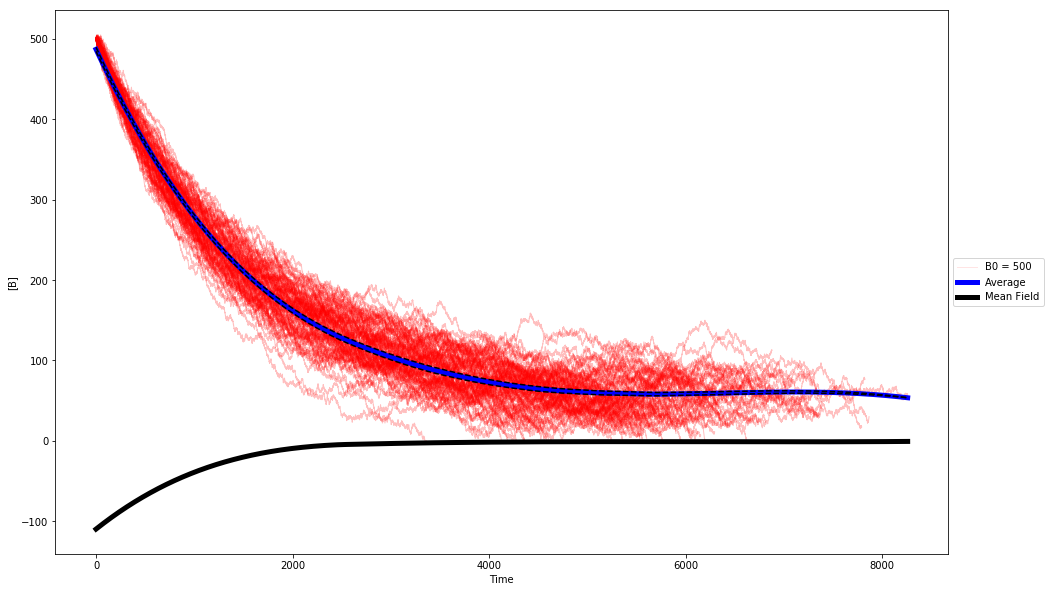

In [23]:
#----------------------------------------Situation 1
N=1000
B0=[500]
beta=0.51
gamma=0.5
Tmax=75

writeLabel = True
iterations = 100
plotCols = ['r', 'c', 'y', 'm', 'b', 'k', 'g', 'c']
B_vals, mf = [],[]


plt.figure(figsize=(16,10))
for x in range(iterations):
    clear_output(wait=True)
    
    for y in range(len(B0)):
        T, A, B = gillespie_ABA(N,B0[y],beta,gamma,Tmax)
        B_vals.append(B)
        
        #Only Labels the first iteration of each R value plot
        if writeLabel:
            plt.plot(B, plotCols[y], label="B0 = {}".format(B0[y]),alpha=0.1,linewidth=1)
        else:
            plt.plot(B, plotCols[y],alpha=0.25,linewidth=1)
    writeLabel = False
        
    #Plot Legend   
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.xlabel("Time")
    plt.ylabel("[B]")
    #print("Current progress: ",np.round(x/iterations *100, 2), "%")
    

    
#Plot Average and Error-bar lines
avg = calculateAverage(B_vals,1)
upperBar = errorBar(B_vals, True)
lowerBar = errorBar(B_vals, False)
plt.plot(savgol_filter(avg, 5001, 3), 'b',linewidth=5, label='Average')
plt.plot(savgol_filter(upperBar, 5001, 3), 'k--')
plt.plot(savgol_filter(lowerBar, 5001, 3), 'k--')


#Plot Mean-Field
for x in range(len(avg)):
    mf.append(meanField(avg[x], N, beta, gamma))
plt.plot(savgol_filter(mf, 5001, 3), 'k', linewidth=5, label="Mean Field")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

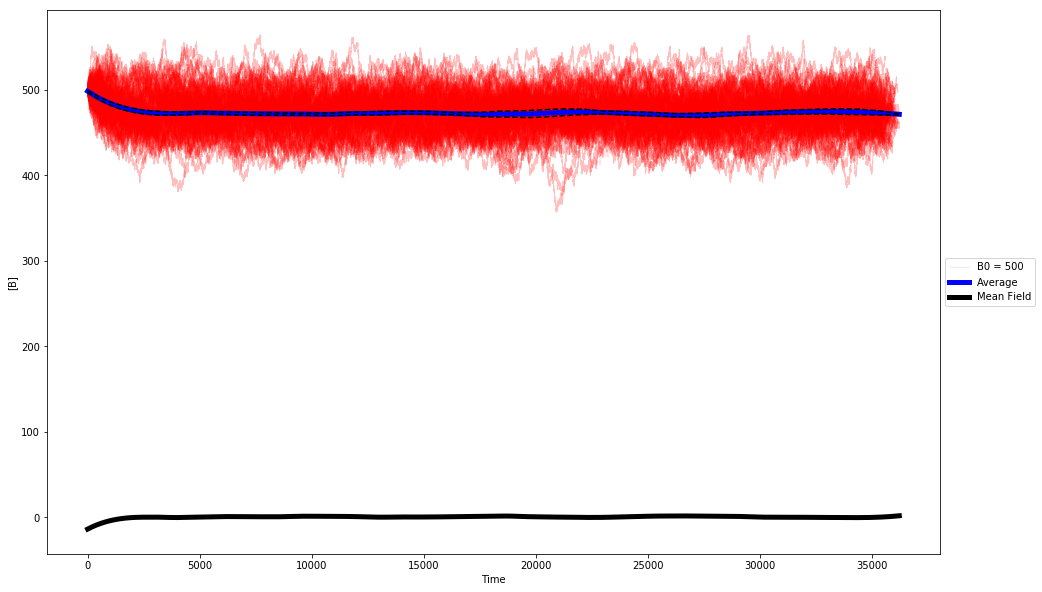

In [24]:
#--------------------------------------------------Scenario 2
N=1000
B0=[500]
beta=0.95
gamma=0.5
Tmax=75

writeLabel = True
iterations = 100
plotCols = ['r', 'c', 'y', 'm', 'b', 'k', 'g', 'c']
B_vals, mf = [],[]


plt.figure(figsize=(16,10))
for x in range(iterations):
    clear_output(wait=True)
    
    for y in range(len(B0)):
        T, A, B = gillespie_ABA(N,B0[y],beta,gamma,Tmax)
        B_vals.append(B)
        
        #Only Labels the first iteration of each R value plot
        if writeLabel:
            plt.plot(B, plotCols[y], label="B0 = {}".format(B0[y]),alpha=0.1,linewidth=1)
        else:
            plt.plot(B, plotCols[y],alpha=0.25,linewidth=1)
    writeLabel = False
        
    #Plot Legend   
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.xlabel("Time")
    plt.ylabel("[B]")
    #print("Current progress: ",np.round(x/iterations *100, 2), "%")
    

    
#Plot Average and Error-bar lines
avg = calculateAverage(B_vals,1)
upperBar = errorBar(B_vals, True)
lowerBar = errorBar(B_vals, False)
plt.plot(savgol_filter(avg, 7501, 3), 'b',linewidth=5, label='Average')
plt.plot(savgol_filter(upperBar, 7501, 3), 'k--')
plt.plot(savgol_filter(lowerBar, 7501, 3), 'k--')


#Plot Mean-Field
for x in range(len(avg)):
    mf.append(meanField(avg[x], N, beta, gamma))
plt.plot(savgol_filter(mf, 5001, 3), 'k', linewidth=5, label="Mean Field")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

Suggestion to improve general agreement:

Force B to stay greater than 0, particularly when $B_0 = 1$, this offers the circumstances that provide the greatest discrepancy between the theoretical and empirical solutions due to the stochastic nature of Gillespie that isn't accounted for by the mean-field equation.